# Mountain Car with Policy Gradient

<img src="mountaincar.gif" alt="environment">

In [1]:
import numpy as np
from agent import Agent
from environment import Environment
from rlglue import RLGlue
import time
import tensorflow as tf
from policy import Policy
from bfunction import BFunction
from vfunction import VFunction
import matplotlib.pyplot as plt

In [2]:
class MountainCar(Environment):
    def env_init(self, env_info={}):
        reward = None
        observation = None
        is_terminal = None
        self.reward_obs_term = (reward, observation, is_terminal)

        self.rand_generator = np.random.RandomState(env_info.get("seed"))
        
        self.left_bound = -1.2
        self.right_bound = 0.5
        self.actions = ['FULL THROTTLE REVERSE', 'ZERO THROTTLE', 'FULL THROTTLE FORWARD']
        
    def env_start(self):
        reward = 0.
        
        position = np.random.uniform(-0.6, -0.4)
        velocity = 0.
        self.current_state = (position, velocity)
        state = self.current_state
        
        is_terminal = False
        
        self.reward_obs_term = [reward, state, is_terminal]
        return self.reward_obs_term[1]
    
    def env_step(self, action):
        position, velocity = self.current_state
        
        velocity = self.env_bound_velocity(velocity + 0.001*(action-1) - 0.0025*np.cos(3*position))
        position = self.env_bound_position(position + velocity)
        
        reward = -1
        is_terminal = False
        
        if position == self.left_bound:
            velocity = 0.
        elif position == self.right_bound:    
            reward = 0.
            is_terminal = True
        
        self.current_state = (position, velocity)
        
        self.reward_obs_term = [reward, self.current_state, is_terminal]

        return self.reward_obs_term

    def env_cleanup(self):
        self.current_state = None
        
    def env_bound_velocity(self, velocity):
        if velocity > 0.07:
            return 0.07
        if velocity < -0.07:
            return -0.07
        return velocity

    def env_bound_position(self, position):
        if position > 0.5:
            return 0.5
        if position < -1.2:
            return -1.2
        return position

In [3]:
class MonteCarloControl(Agent):
    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        
        self.discount = agent_info.get("discount")
        
        self.b = BFunction()
        self.policy = Policy()
            
    def agent_start(self, state):
        self.episode_data = []

        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_step(self, reward, state): 
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        action = self.agent_action(state)
        
        self.last_state = state
        self.last_action = action

        return action

    def agent_end(self, reward):         
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        X_train = []
        Z_train = []
        Y_train = []
        
        g = 0
        for i in range(len(self.episode_data)-1, -1, -1):
            s, a, r = self.episode_data[i]
                        
            X_train.append([s[0], s[1]])
            
            g = r + self.discount*g
            Y_train.append([g])
            
            d = g - self.b.predict(np.array([[s[0], s[1]]]))

            one_hot = np.zeros((1,3))
            one_hot[0,a] = 1.
            d = d*one_hot
        
            Z_train.append(d)
            
        self.b.fit(X_train, Y_train)
        self.policy.fit(X_train, Z_train)
            
    def agent_cleanup(self):
        self.last_state = None
        self.last_action = None
                       
    def agent_action(self, state):
        s, t = state 
        p = self.policy.predict(np.array([[s,t]]))
        return self.rand_generator.choice(range(p.shape[1]), p=p.flatten())    

In [4]:
class PolicyIteration(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {}'.format(episode+1, num_episodes, self.num_steps))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
        self.rl_cleanup()
        return self.agent.policy

-----

In [5]:
env_info = {}

mountain_car = MountainCar()

In [6]:
agent_info = {"discount": 1.}

montecarlo_control = MonteCarloControl()

In [7]:
num_episodes = 200
max_steps_this_episode = 15000

policy_iteration = PolicyIteration(env=mountain_car, agent=montecarlo_control)
optimal_policy = policy_iteration.rl_run(env_info=env_info, 
                                         agent_info=agent_info,
                                         num_episodes=num_episodes, 
                                         max_steps_this_episode=max_steps_this_episode)

Episode: 1/200 - Steps: 9309
----- 5.433s -----
Episode: 2/200 - Steps: 15000
----- 10.802s -----
Episode: 3/200 - Steps: 7956
----- 4.558s -----
Episode: 4/200 - Steps: 15000
----- 11.007s -----
Episode: 5/200 - Steps: 2608
----- 1.456s -----
Episode: 6/200 - Steps: 4566
----- 2.649s -----
Episode: 7/200 - Steps: 10320
----- 6.006s -----
Episode: 8/200 - Steps: 6015
----- 3.44s -----
Episode: 9/200 - Steps: 10850
----- 6.645s -----
Episode: 10/200 - Steps: 2884
----- 1.623s -----
Episode: 11/200 - Steps: 14871
----- 10.704s -----
Episode: 12/200 - Steps: 3207
----- 1.82s -----
Episode: 13/200 - Steps: 2742
----- 1.534s -----
Episode: 14/200 - Steps: 2670
----- 1.49s -----
Episode: 15/200 - Steps: 3271
----- 1.83s -----
Episode: 16/200 - Steps: 2741
----- 1.553s -----
Episode: 17/200 - Steps: 4418
----- 2.485s -----
Episode: 18/200 - Steps: 13532
----- 9.399s -----
Episode: 19/200 - Steps: 3608
----- 2.022s -----
Episode: 20/200 - Steps: 2724
----- 1.535s -----
Episode: 21/200 - Steps:

Episode: 167/200 - Steps: 1686
----- 0.93s -----
Episode: 168/200 - Steps: 13100
----- 8.793s -----
Episode: 169/200 - Steps: 14118
----- 9.392s -----
Episode: 170/200 - Steps: 4679
----- 2.508s -----
Episode: 171/200 - Steps: 3808
----- 2.033s -----
Episode: 172/200 - Steps: 3458
----- 1.848s -----
Episode: 173/200 - Steps: 1572
----- 0.838s -----
Episode: 174/200 - Steps: 7681
----- 4.165s -----
Episode: 175/200 - Steps: 9181
----- 5.027s -----
Episode: 176/200 - Steps: 3725
----- 1.988s -----
Episode: 177/200 - Steps: 2837
----- 1.524s -----
Episode: 178/200 - Steps: 3409
----- 1.83s -----
Episode: 179/200 - Steps: 8661
----- 4.737s -----
Episode: 180/200 - Steps: 15000
----- 10.491s -----
Episode: 181/200 - Steps: 2095
----- 1.128s -----
Episode: 182/200 - Steps: 2448
----- 1.303s -----
Episode: 183/200 - Steps: 10324
----- 5.829s -----
Episode: 184/200 - Steps: 3405
----- 1.828s -----
Episode: 185/200 - Steps: 5927
----- 3.21s -----
Episode: 186/200 - Steps: 4569
----- 2.453s ----

In [8]:
S_test = []
for x in np.round(np.linspace(-1.2, 0.5, 50), 3):
    for v in np.round(np.linspace(-0.07, 0.07, 50), 3):
        S_test.append([x,v])
S_test = np.array(S_test)
S_test

array([[-1.2  , -0.07 ],
       [-1.2  , -0.067],
       [-1.2  , -0.064],
       ...,
       [ 0.5  ,  0.064],
       [ 0.5  ,  0.067],
       [ 0.5  ,  0.07 ]])

In [9]:
optimal_policy.predict(S_test)

array([[0.23155381, 0.29371724, 0.474729  ],
       [0.23155381, 0.2937172 , 0.47472903],
       [0.23155376, 0.29371715, 0.47472906],
       ...,
       [0.23155192, 0.2937141 , 0.47473392],
       [0.2315519 , 0.29371408, 0.47473398],
       [0.23155189, 0.29371405, 0.47473407]], dtype=float32)

-----

In [10]:
class MonteCarloEvaluation(Agent):
    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get('seed'))
        
        self.discount = agent_info.get("discount")
        self.policy = agent_info.get("policy")

        self.v = VFunction()
        self.episodes = []

    def agent_start(self, state):
        self.episode_data = []
        
        self.episodes.append([])
        self.episodes[-1].append(state)

        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action
        
        return action

    def agent_step(self, reward, state):
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        self.episodes[-1].append(state)

        action = self.agent_action(state)
        self.last_state = state
        self.last_action = action

        return action

    def agent_end(self, reward):
        self.episode_data.append((self.last_state, self.last_action, reward))
        
        X_train = []
        Y_train = []
        
        target = 0
        for i in range(len(self.episode_data)-1, -1, -1):
            s, a, r = self.episode_data[i]
            
            X_train.append([s[0], s[1]])
            
            target = r + self.discount*target
            
            Y_train.append([target])
             
        self.v.fit(X_train, Y_train)
        
    def agent_cleanup(self):
        self.last_state = None

    def agent_action(self, state):
        position, velocity = state
        p = self.policy.predict(np.array([[position, velocity]]))
        return self.rand_generator.choice(range(p.shape[1]), p=p.flatten())

In [11]:
class PolicyEvaluation(RLGlue):
    def rl_run(self, env_info, agent_info, num_episodes, max_steps_this_episode, verbose=True):
        self.rl_init(agent_info, env_info)
        for episode in range(num_episodes):
            start_time = time.time()
            self.rl_episode(max_steps_this_episode)
            now = time.time()
            duration = now - start_time
            if verbose:
                print('Episode: {}/{} - Steps: {}'.format(episode+1, num_episodes, self.num_steps))
                print('----- {}s -----'.format(np.round(1000*duration)/1000))
        self.rl_cleanup()
        return self.agent.v

-----

In [12]:
agent_info = {"discount": 1.,
              "policy": optimal_policy}

montecarlo_evaluation = MonteCarloEvaluation()

In [13]:
num_episodes = 200
max_steps_this_episode = 15000 

policy_evaluation = PolicyEvaluation(env=mountain_car, agent=montecarlo_evaluation)
v = policy_evaluation.rl_run(env_info=env_info,
                             agent_info=agent_info,
                             num_episodes=num_episodes,
                             max_steps_this_episode=max_steps_this_episode)

Episode: 1/200 - Steps: 5314
----- 1.499s -----
Episode: 2/200 - Steps: 2699
----- 0.768s -----
Episode: 3/200 - Steps: 2552
----- 0.722s -----
Episode: 4/200 - Steps: 1984
----- 0.565s -----
Episode: 5/200 - Steps: 4428
----- 1.236s -----
Episode: 6/200 - Steps: 6164
----- 1.728s -----
Episode: 7/200 - Steps: 3760
----- 1.057s -----
Episode: 8/200 - Steps: 7457
----- 2.138s -----
Episode: 9/200 - Steps: 1019
----- 0.294s -----
Episode: 10/200 - Steps: 6323
----- 1.77s -----
Episode: 11/200 - Steps: 1192
----- 0.341s -----
Episode: 12/200 - Steps: 4517
----- 1.273s -----
Episode: 13/200 - Steps: 2969
----- 0.843s -----
Episode: 14/200 - Steps: 2546
----- 0.726s -----
Episode: 15/200 - Steps: 4425
----- 1.249s -----
Episode: 16/200 - Steps: 8363
----- 2.357s -----
Episode: 17/200 - Steps: 3014
----- 0.851s -----
Episode: 18/200 - Steps: 4125
----- 1.157s -----
Episode: 19/200 - Steps: 5686
----- 1.59s -----
Episode: 20/200 - Steps: 15000
----- 4.248s -----
Episode: 21/200 - Steps: 8869


Episode: 168/200 - Steps: 4917
----- 1.366s -----
Episode: 169/200 - Steps: 1214
----- 0.346s -----
Episode: 170/200 - Steps: 11688
----- 3.226s -----
Episode: 171/200 - Steps: 6040
----- 1.743s -----
Episode: 172/200 - Steps: 13516
----- 3.755s -----
Episode: 173/200 - Steps: 938
----- 0.271s -----
Episode: 174/200 - Steps: 5581
----- 1.553s -----
Episode: 175/200 - Steps: 1094
----- 0.331s -----
Episode: 176/200 - Steps: 12957
----- 3.587s -----
Episode: 177/200 - Steps: 4423
----- 1.242s -----
Episode: 178/200 - Steps: 7615
----- 2.116s -----
Episode: 179/200 - Steps: 5362
----- 1.49s -----
Episode: 180/200 - Steps: 6525
----- 1.821s -----
Episode: 181/200 - Steps: 1516
----- 0.432s -----
Episode: 182/200 - Steps: 4380
----- 1.218s -----
Episode: 183/200 - Steps: 4303
----- 1.269s -----
Episode: 184/200 - Steps: 9428
----- 2.614s -----
Episode: 185/200 - Steps: 3197
----- 0.9s -----
Episode: 186/200 - Steps: 2607
----- 0.73s -----
Episode: 187/200 - Steps: 9886
----- 2.754s -----
Ep

In [14]:
policy_evaluation.agent.v.predict(S_test)

array([[-13.581172],
       [-13.840362],
       [-14.099549],
       ...,
       [-36.38796 ],
       [-36.647156],
       [-36.906338]], dtype=float32)

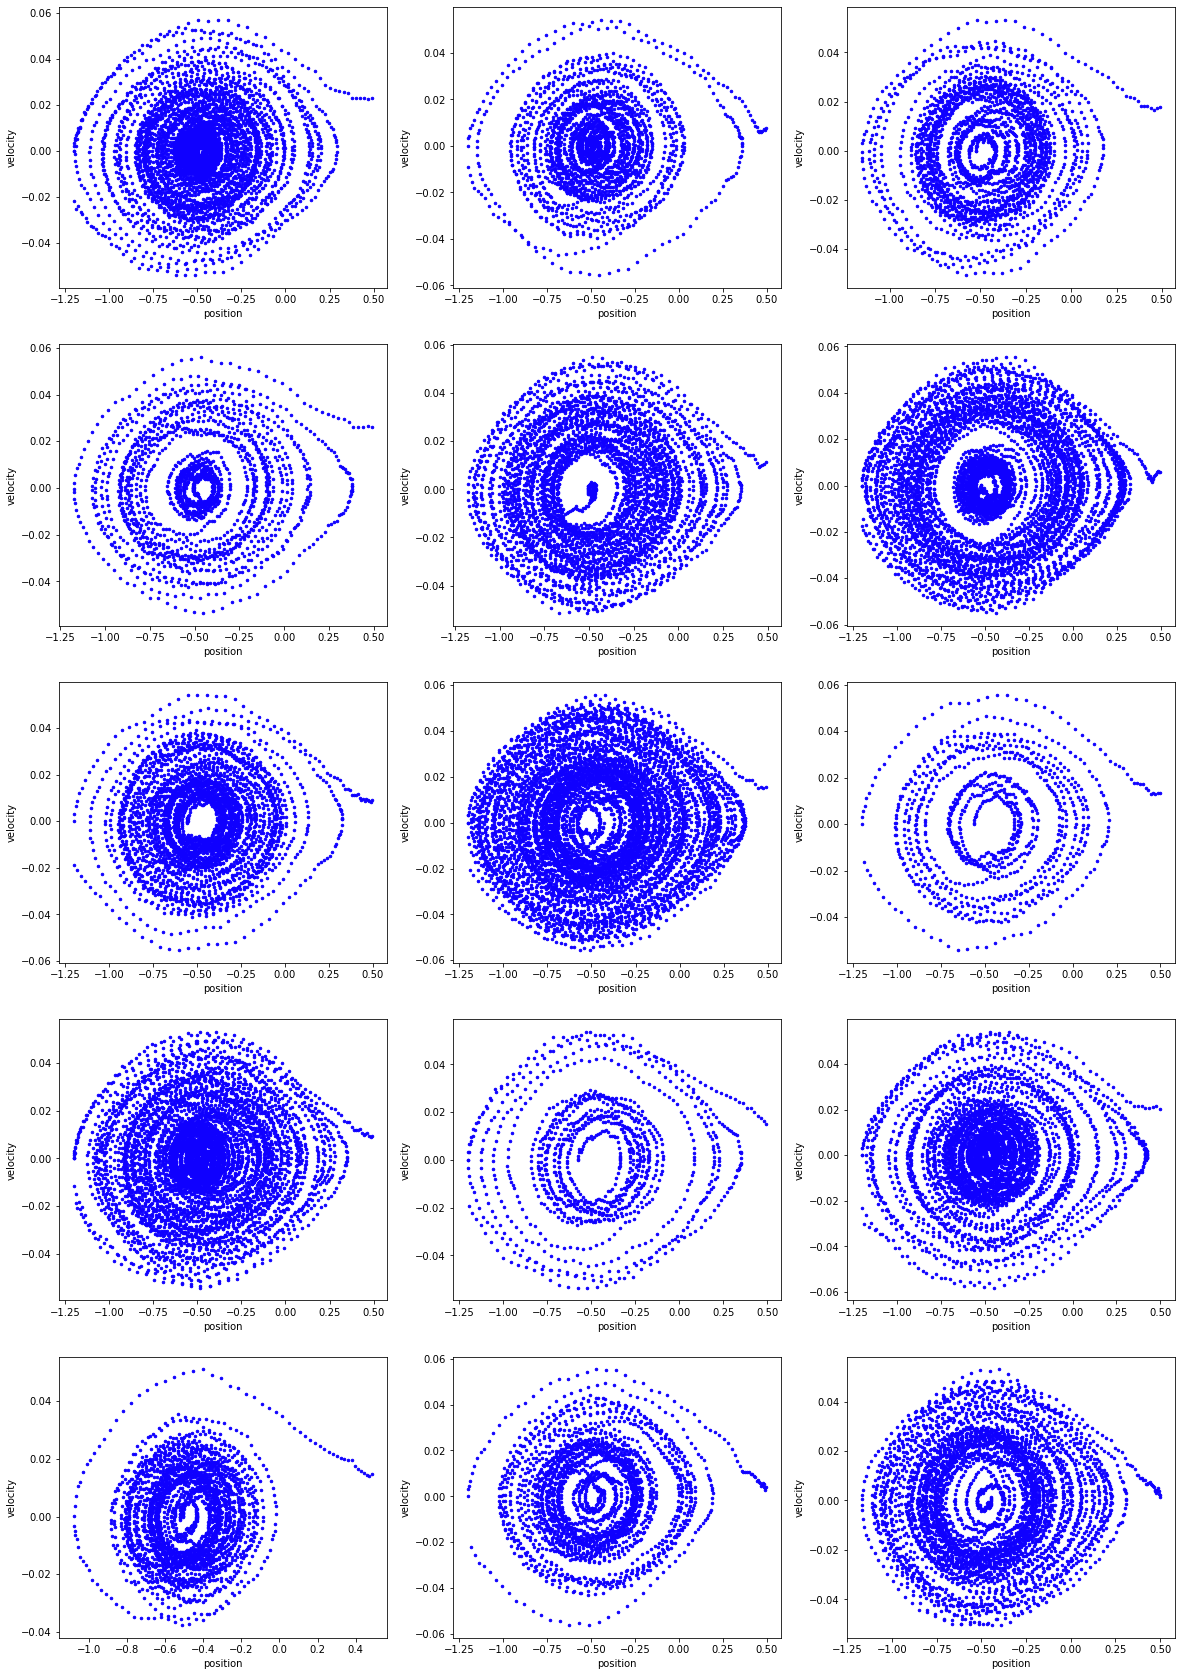

In [15]:
fig, axes = plt.subplots(figsize=(20,30),nrows=5, ncols=3)

for i in range(5):
    for j in range(3):
        x = np.array(policy_evaluation.agent.episodes[i*3+j])[:,0]
        y = np.array(policy_evaluation.agent.episodes[i*3+j])[:,1]

        axes[i,j].set_xlabel('position')
        axes[i,j].set_ylabel('velocity')
        axes[i,j].plot(x, y, marker='.', color='#0F00FF', markersize=5, linestyle='')